In [1]:
import numpy as np
import pandas as pd
import sys
import os
import time
import copy
import matplotlib.pyplot as plt
import cv2

from IPython.display import Image, display


import tensorflow as tf
import sklearn
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

Using TensorFlow backend.


In [2]:
ls

A2 Tests.ipynb               predicates.txt
HW2.pdf                      sample_submission.txt
__pycache__/                 test_images.txt
classes.txt                  testclasses.txt
eval_awa.py                  train_model_1.py
images_128x128/              trainclasses.txt
predicate-matrix-binary.txt


In [3]:
ls images_128x128

antelope/        elephant/        lion/            seal/
bat/             fox/             mole/            sheep/
beaver/          german+shepherd/ moose/           siamese+cat/
blue+whale/      giant+panda/     mouse/           skunk/
bobcat/          giraffe/         otter/           spider+monkey/
buffalo/         gorilla/         ox/              squirrel/
chihuahua/       grizzly+bear/    persian+cat/     tiger/
chimpanzee/      hamster/         pig/             walrus/
collie/          hippopotamus/    polar+bear/      weasel/
cow/             horse/           rabbit/          wolf/
dalmatian/       humpback+whale/  raccoon/         zebra/
deer/            killer+whale/    rat/
dolphin/         leopard/         rhinoceros/


In [4]:
#for i in range(3):
#    display(Image(filename='images_128x128/antelope/antelope_1000{}.jpg'.format(i+1)))

In [5]:
classes = pd.read_csv("classes.txt", header=None) 
predicate_matrix_binary = pd.read_csv("predicate-matrix-binary.txt", header=None) # binary N by M non-symmetric matrix
predicates = pd.read_csv("predicates.txt", header=None)
sample_submission = pd.read_csv("sample_submission.txt", header=None)
test_images = pd.read_csv("test_images.txt", header=None)
testclasses = pd.read_csv("testclasses.txt", header=None)
trainclasses = pd.read_csv("trainclasses.txt", header=None)

In [6]:
id_to_feat = {}
for i, string in enumerate(predicates.iloc[:,0]):
    id_to_feat[i] = string.split()[1]

In [7]:
n_features = None
class_to_feat = {}
name_to_id = {}
all_classes = []
for i, c in enumerate(classes[0]):
    c_name = c.split()[1]
    class_to_feat[c_name] = np.array([int(binary) for binary in predicate_matrix_binary.iloc[i, 0].split()])
    name_to_id[c_name] = i
    all_classes.append(c_name)
    if not n_features: n_features = len(class_to_feat[c_name])

train_classes, test_classes = [], []
for c in trainclasses[0]: train_classes.append(c.split()[0])
for c in testclasses[0]: test_classes.append(c.split()[0])

In [8]:
ls images_128x128/

antelope/        elephant/        lion/            seal/
bat/             fox/             mole/            sheep/
beaver/          german+shepherd/ moose/           siamese+cat/
blue+whale/      giant+panda/     mouse/           skunk/
bobcat/          giraffe/         otter/           spider+monkey/
buffalo/         gorilla/         ox/              squirrel/
chihuahua/       grizzly+bear/    persian+cat/     tiger/
chimpanzee/      hamster/         pig/             walrus/
collie/          hippopotamus/    polar+bear/      weasel/
cow/             horse/           rabbit/          wolf/
dalmatian/       humpback+whale/  raccoon/         zebra/
deer/            killer+whale/    rat/
dolphin/         leopard/         rhinoceros/


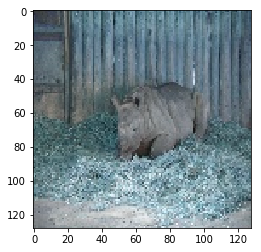

In [9]:
test_img = "images_128x128/rhinoceros/rhinoceros_10066.jpg"
cv2_img = cv2.imread(test_img, 1)
img = array_to_img(cv2_img)
plt.imshow(img_to_array(img) / 255.0)

In [10]:
train_imgs = {}
test_imgs = {}
data_dir = "images_128x128"
for animal_name in os.listdir(data_dir):
    if animal_name in train_classes:
        train_imgs[animal_name] = []
        animal_dir = data_dir + "/" + animal_name + "/"
        for img_name in os.listdir(animal_dir):
            img = plt.imread(animal_dir + img_name)
            train_imgs[animal_name].append(img)
            
    if animal_name in test_classes:
        test_imgs[animal_name] = []
        animal_dir = data_dir + "/" + animal_name + "/"
        for img_name in os.listdir(animal_dir):
            img = plt.imread(animal_dir + img_name)
            test_imgs[animal_name].append(img)

In [11]:
all_imgs = {**train_imgs, **test_imgs}

In [113]:
from sklearn.decomposition import PCA

matrix = []
for k, v in class_to_feat.items():
    matrix.append(v)
feat_matrix = np.array(matrix)
pca = PCA(n_components=25)
pca.fit(feat_matrix)
print(pca.explained_variance_ratio_.sum()) 

0.9222520259921839


In [12]:
def load_cross_validation(k, classes):
    validation_sets = []
    n = len(classes)
    subset_size = int(n / k)
    split_classes = [classes[x:x + subset_size] for x in range(0, n, subset_size)]
    for test_classes in split_classes:
        training_classes = [c for c in classes if c not in test_classes]
        validation_sets.append((training_classes, test_classes))
    return validation_sets

cross_val_classes = load_cross_validation(5, train_classes)

In [40]:
def class_to_data(animal):
    x_data, y_data = [], []
    labels = class_to_feat[animal].tolist()
    x_data += all_imgs[animal]
    y_data += len(all_imgs[animal]) * [labels]
    return x_data, y_data

def all_data(classes):
    x_data, y_data = [], []
    for animal in classes:
        x, y = class_to_data(animal)
        x_data += x
        y_data += y
    return x_data, y_data
    
x_antelope, y_antelope = class_to_data("antelope")

In [43]:
np.array(y_antelope)[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0])

In [51]:
x, y = all_data(train_classes)
model = Sequential()
model.add(Conv2D(32, kernel_size=5, activation='relu', padding='same', input_shape=(128,128,3)))
model.add(Conv2D(32, kernel_size=5, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=5, activation='relu', padding='same'))
model.add(Conv2D(16, kernel_size=5, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))    # shape == 32 x 32 here
model.add(Conv2D(16, kernel_size=3, activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(n_features, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(np.array(x), np.array(y), epochs=2, verbose=1, shuffle=True)

Epoch 1/2
30337/30337 [==============================] - 1884s 62ms/step - loss: 126.5041 - acc: 0.0060
Epoch 2/2
30337/30337 [==============================] - 1871s 62ms/step - loss: 124.8471 - acc: 0.0016


In [71]:
test_classes

['chimpanzee',
 'giant+panda',
 'leopard',
 'persian+cat',
 'pig',
 'hippopotamus',
 'humpback+whale',
 'raccoon',
 'rat',
 'seal']

In [87]:
img_loss = lambda i, x, y: np.abs(y[i] - np.round(model.predict(np.expand_dims(x[i], axis=0))[0]))

animal_loss = {}
for animal in test_classes:
    print("Animal: " + animal)
    x, y = class_to_data(animal)
    animal_loss[animal] = np.mean(np.array([img_loss(i, x, y) for i in range(len(y))]), axis=0)

Animal: chimpanzee
Animal: giant+panda
Animal: leopard
Animal: persian+cat
Animal: pig
Animal: hippopotamus
Animal: humpback+whale
Animal: raccoon
Animal: rat
Animal: seal


In [116]:
def img_to_prob(img, class_candidates):
    scores = []
    s = model.predict(np.expand_dims(img, axis=0))[0]
    probs = np.zeros(len(class_candidates))
    for i, animal in enumerate(class_candidates):
        probs[i] = np.prod(np.abs(s - 1.0 + class_to_feat[animal]))
    return probs

p = img_to_prob(x_antelope[4], all_classes)
ind = p.argsort()[-3:]
for i in ind:
    print(all_classes[i])
    print(p[i])

zebra
2.638857669947554e-14
deer
9.09303763940289e-12
antelope
1.2306770749116776e-09


In [120]:
def labeled_data(classes):
    x_data, y_data = [], []
    for animal in classes:
        x, y = class_to_data(animal)
        x_data += x
        y_data += len(x) * [animal]
    return x_data, y_data

x, y = labeled_data(test_classes)
corrects = np.zeros(len(x))
for i, img in enumerate(x):
    probs = img_to_prob(img, test_classes)
    corrects[i] = (y[i] == test_classes[probs.argsort()[-1]])
print(np.mean(corrects))

0.1561918396564066
